In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import http.client

# Data exploration and preprocessing
import spacy
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

# Build and train models
import keras_tuner as kt
from collections import Counter
from transformers import BertTokenizer, TFBertForSequenceClassification
import faiss
from sentence_transformers import SentenceTransformer
import voyageai
from voyageai import Client
import os
from tqdm import tqdm

c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Scraping of job listings from Adzuna API

In [ ]:
# Adzuna API credentials and base URL
APP_ID = "ee5e2937"
APP_KEY = "b85d8687343a341fcf5bf76131a48ad2"
BASE_URL = "https://api.adzuna.com/v1/api/jobs/us/search/{}"

all_jobs = []

# Loop through first 10 pages
for page in range(1, 11):  # pages 1 to 11
    url = BASE_URL.format(page)
    params = {
        "app_id": APP_ID,
        "app_key": APP_KEY,
        "results_per_page": 50,
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        for job in data.get("results", []):
            all_jobs.append({
            "id": job.get("id"),
            "title": job.get("title"),
            "company": job.get("company", {}).get("display_name"),
            "location": job.get("location", {}).get("display_name"),
            "category": job.get("category", {}).get("label"),
            "created": job.get("created"),
            "url": job.get("redirect_url"),
            "description": job.get("description"),
            "salary_min": job.get("salary_min"),
            "salary_max": job.get("salary_max"),
            "contract_type": job.get("contract_type"),
            "contract_time": job.get("contract_time"),
            })
    else:
        print(f"Failed on page {page}: {response.status_code}")
        print(response.text)

# Save all jobs to CSV
df = pd.DataFrame(all_jobs)
df.to_csv("adzuna_jobs.csv", index=False)
print("Saved jobs to adzuna_jobs.csv")


Saved jobs to adzuna_jobs.csv


In [ ]:
# Adzuna API credentials and base URL for UK jobs
APP_ID = "ee5e2937"
APP_KEY = "b85d8687343a341fcf5bf76131a48ad2"
BASE_URL = "https://api.adzuna.com/v1/api/jobs/gb/search/{}"

all_jobs = []

# Loop through first 10 pages
for page in range(1, 11):  # pages 1 to 11
    url = BASE_URL.format(page)
    params = {
        "app_id": APP_ID,
        "app_key": APP_KEY,
        "results_per_page": 50,
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        for job in data.get("results", []):
            all_jobs.append({
            "id": job.get("id"),
            "title": job.get("title"),
            "company": job.get("company", {}).get("display_name"),
            "location": job.get("location", {}).get("display_name"),
            "category": job.get("category", {}).get("label"),
            "created": job.get("created"),
            "url": job.get("redirect_url"),
            "description": job.get("description"),
            "salary_min": job.get("salary_min"),
            "salary_max": job.get("salary_max"),
            "contract_type": job.get("contract_type"),
            "contract_time": job.get("contract_time"),
            })
    else:
        print(f"Failed on page {page}: {response.status_code}")
        print(response.text)

# Save all jobs to CSV
df = pd.DataFrame(all_jobs)
df.to_csv("adzuna_jobs_gb.csv", index=False)
print("Saved jobs to adzuna_jobs_gb.csv")

Saved jobs to adzuna_jobs_gb.csv


## 2. Loading of the jobs and resume dataset

In [57]:
jobs_gb = pd.read_csv('adzuna_jobs_gb.csv')
jobs_gb.head()

,id,title,company,location,category,created,url,description,salary_min,salary_max,contract_type,contract_time
0,5185229320,Early Years Educator Nursery,Partou,"Ware, Hertfordshire",Teaching Jobs,2025-05-07T14:32:36Z,https://www.adzuna.co.uk/jobs/details/51852293...,"Join Partou, where we put children in the lead...",27600.0,27600.0,permanent,part_time
1,5172986638,Housekeeping Assistant - Bank - Care Home,Barchester Healthcare,"Melbourn, Royston",Domestic help & Cleaning Jobs,2025-05-01T13:32:39Z,https://www.adzuna.co.uk/jobs/details/51729866...,ABOUT THE ROLE As a Bank Housekeeping Assistan...,29619.0,29619.0,NaN,NaN
2,5190346944,Care Home Administrator,Barchester Healthcare,"Harlow Green, Gateshead",Admin Jobs,2025-05-09T13:37:28Z,https://www.adzuna.co.uk/jobs/details/51903469...,Barchester Healthcare are looking for an exper...,28000.0,28000.0,permanent,NaN
3,5149584869,Care Assistant - Bank - Care Home,Barchester Healthcare,"Wilton, Salisbury",Healthcare & Nursing Jobs,2025-04-17T13:30:03Z,https://www.adzuna.co.uk/jobs/details/51495848...,ABOUT THE ROLE As a Bank Care Assistant at a B...,33342.0,33342.0,NaN,NaN
4,5172986642,Activities Assistant - Care Home,Barchester Healthcare,"Badgeworth, Cheltenham",Hospitality & Catering Jobs,2025-05-01T13:32:39Z,https://www.adzuna.co.uk/jobs/details/51729866...,ABOUT THE ROLE As an Activities Assistant at a...,26436.0,26436.0,permanent,NaN


In [45]:
# Load the resumes data
resumes = pd.read_csv("Resume.csv")
resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## 3. Data Preprocessing

In [58]:
jobs_gb['category'].value_counts()

category
Teaching Jobs                       127
Engineering Jobs                     50
IT Jobs                              39
Healthcare & Nursing Jobs            37
Social work Jobs                     30
Legal Jobs                           29
Sales Jobs                           23
Customer Services Jobs               23
Hospitality & Catering Jobs          22
Logistics & Warehouse Jobs           18
Trade & Construction Jobs            15
Accounting & Finance Jobs            13
Graduate Jobs                        10
Retail Jobs                          10
Manufacturing Jobs                   10
PR, Advertising & Marketing Jobs      9
Domestic help & Cleaning Jobs         8
Admin Jobs                            6
HR & Recruitment Jobs                 6
Part time Jobs                        4
Consultancy Jobs                      3
Maintenance Jobs                      3
Other/General Jobs                    2
Property Jobs                         2
Creative & Design Jobs         

In [47]:
# Check the number of unique categories in the resumes dataset
resumes['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

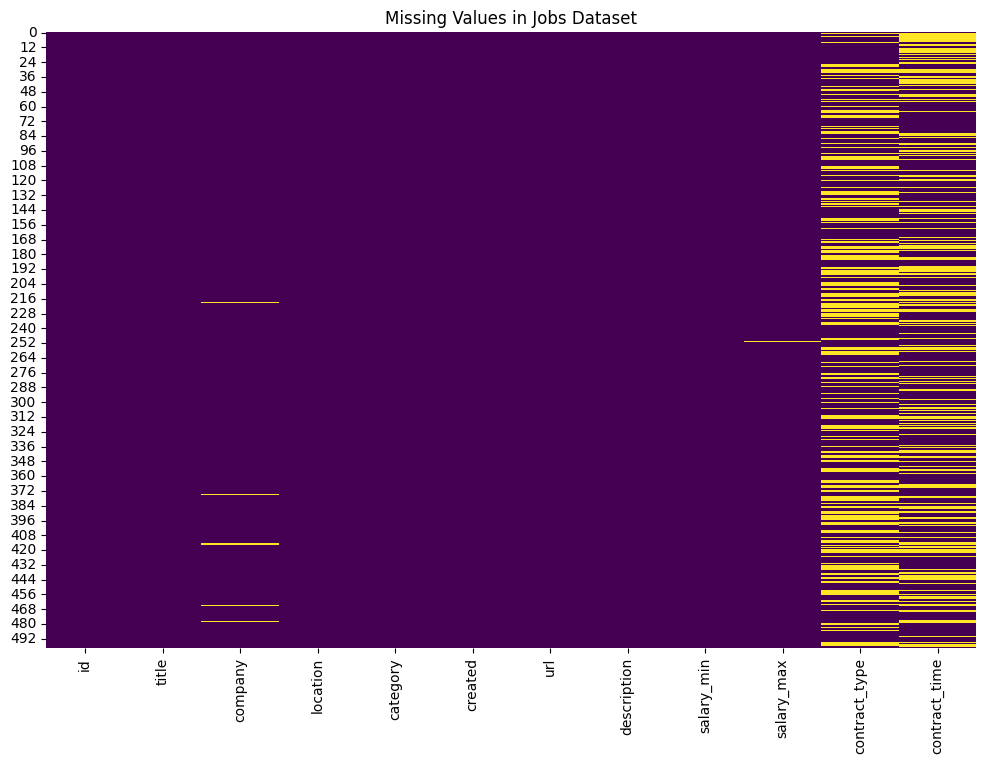

In [48]:
# use heatmap to visualize the missing values in the jobs dataset
plt.figure(figsize=(12, 8))
sns.heatmap(jobs_gb.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Jobs Dataset")
plt.show()

In [59]:
#resumes.isnull().sum()  no missing values in the resumes dataset
# check for missing values in the different columns
jobs_gb.isnull().sum()

id                 0
title              0
company            5
location           0
category           0
created            0
url                0
description        0
salary_min         0
salary_max         1
contract_type    183
contract_time    169
dtype: int64

In [60]:
# Fill the missing values in contract type, contract time and company with 'unknown' and salary max with 0
jobs_gb.fillna({'salary_max':0}, inplace=True)
jobs_gb.fillna({'contract_type':'unknown'}, inplace=True)
jobs_gb.fillna({'contract_time':'unknown'}, inplace=True)
jobs_gb.fillna({'commpany':'unknown'}, inplace=True)

In [61]:
# chcek the data types of the columns
jobs_gb.dtypes

id                 int64
title             object
company           object
location          object
category          object
created           object
url               object
description       object
salary_min       float64
salary_max       float64
contract_type     object
contract_time     object
dtype: object

In [63]:
jobs_gb[['salary_min', 'salary_max']].describe()

,salary_min,salary_max
count,500.000000,500.000000
mean,36133.845660,44346.551660
std,22708.096319,26237.799317
min,0.000000,0.000000
25%,26436.000000,29120.000000
50%,31650.000000,40000.000000
75%,42050.000000,51179.000000
max,336000.000000,378000.000000


In [64]:
# Create a new column on the average salary
jobs_gb['salary_avg'] = (jobs_gb['salary_min'] + jobs_gb['salary_max']) / 2

In [66]:
# convert to csv
jobs_gb.to_csv('jobs_gb_cleaned.csv', index=False)